In [23]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mhclovac.binding import PanSpecificBindingPredictor, MhcSpecificBindingPredictor



## Pan-specific predictor

In [24]:
data = pd.read_csv('./data/mhc_full_cleaned.csv')
data.dropna(subset=['quant_meas'], inplace=True)
data = data[data['mhc_class'].isin(['I', 'non classical'])]

with open('./data/pseudo.json') as f:
    pseudo_dict = json.load(f)

data = data[data['mhc_allele'].isin(pseudo_dict)]
data['target'] = data['quant_meas'].apply(lambda x: 1 - math.log(max([x, 0.01]), 50.000))

training_data = data.sample(frac=0.7)
test_data = data.drop(training_data.index)

print(f'training samples: {len(training_data)}')
print(f'testing samples: {len(test_data)}')

model = PanSpecificBindingPredictor(class_=1)
model.train(peptides=training_data['peptide'], mhcs=training_data['mhc_allele'], values=training_data['target'])

predictions = model.predict(peptides=test_data['peptide'], mhcs=test_data['mhc_allele'])


training samples: 97058
testing samples: 41597


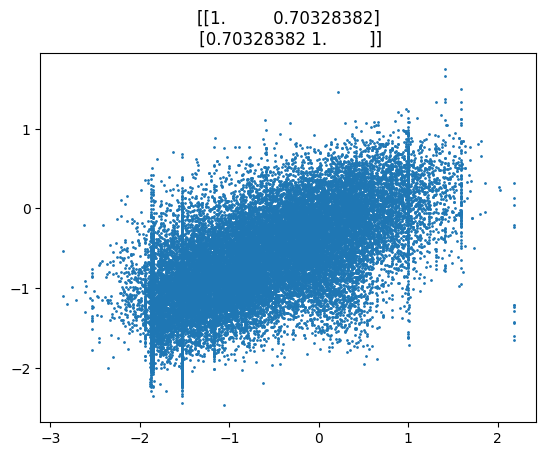

In [25]:
plt.scatter(test_data['target'], predictions, s=1)
plt.title(f'{np.corrcoef(test_data['target'], predictions)}')
plt.show()

## Mhc-specific prediction

In [17]:
data = pd.read_csv('./data/mhc_full_cleaned.csv')
data.dropna(subset=['quant_meas'], inplace=True)
data = data[data['mhc_class'].isin(['I', 'non classical'])]
data['target'] = data['quant_meas'].apply(lambda x: 1 - math.log(max([x, 0.01]), 50.000))

target_values = []
predicted_values = []

for mhc in data['mhc_allele'].unique():
    mhc_data = data[data['mhc_allele'] == mhc]
    mhc_training_data = mhc_data.sample(frac=0.7)
    mhc_test_data = mhc_data.drop(mhc_training_data.index)
    if any([len(mhc_training_data) < 10, len(mhc_test_data) < 1]):
        continue
    print(f'mhc: {mhc}')
    print(f'training samples: {len(mhc_training_data)}')
    print(f'testing samples: {len(mhc_test_data)}')
    
    model = MhcSpecificBindingPredictor(class_=1, mhc=mhc)
    model.train(mhc_training_data['peptide'], mhc_training_data['target'])
    
    predictions = model.predict(mhc_test_data['peptide'])
    target_values.extend(mhc_test_data['target'])
    predicted_values.extend(predictions)

    

mhc: HLA-A*03:01
training samples: 4786
testing samples: 2051
mhc: HLA-A*11:01
training samples: 4365
testing samples: 1871
mhc: HLA-A*02:01
training samples: 12456
testing samples: 5338
mhc: H2-Kb
training samples: 2349
testing samples: 1007
mhc: H2-Db
training samples: 2101
testing samples: 900
mhc: HLA-B*35:01
training samples: 1181
testing samples: 506
mhc: H2-Kk
training samples: 283
testing samples: 121
mhc: HLA-B*07:02
training samples: 2834
testing samples: 1215
mhc: HLA-A*02:02
training samples: 3701
testing samples: 1586
mhc: HLA-A*02:06
training samples: 4136
testing samples: 1772
mhc: HLA-A*68:02
training samples: 4637
testing samples: 1987
mhc: HLA-A*02:03
training samples: 4531
testing samples: 1942
mhc: HLA-A*68:01
training samples: 2143
testing samples: 918
mhc: HLA-A*31:01
training samples: 3419
testing samples: 1465
mhc: HLA-A*33:01
training samples: 2062
testing samples: 883
mhc: H2-Kd
training samples: 398
testing samples: 171
mhc: HLA-A*01:01
training samples: 2831

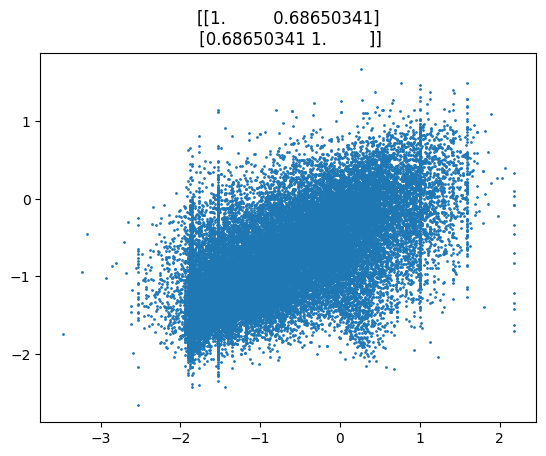

In [22]:
plt.scatter(target_values, predicted_values, s=1)
plt.title(f'{np.corrcoef(target_values, predicted_values)}')
plt.show()
